# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [32]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1) / lmbda))

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Просмотр данных

In [36]:
salary_data = pd.read_csv('../../WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [37]:
salary_data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [38]:
salary_data.columns = ['wages']
salary_data.describe()

,wages
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


## Визуальный анализ ряда

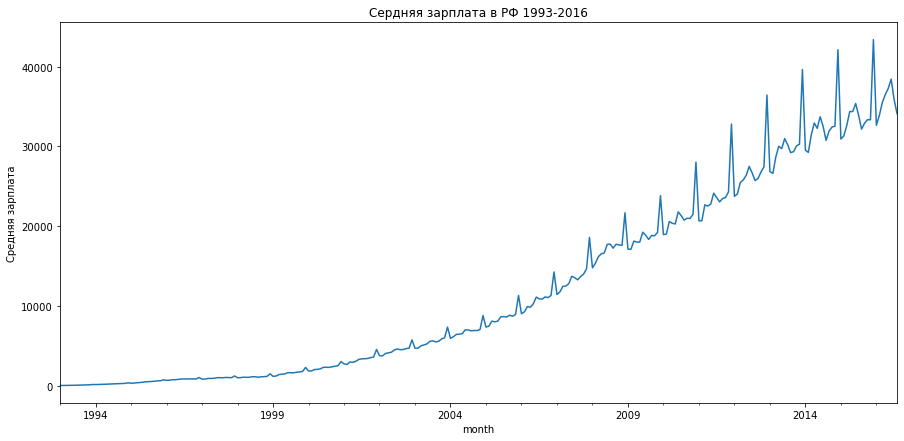

In [39]:
plt.figure(figsize(15,7))
salary_data.wages.plot()
plt.ylabel(u"Средняя зарплата")
plt.title(u"Сердняя зарплата в РФ 1993-2016")
pylab.show();

На графике наблюдается повышающийся тренд. Также видная сезонность: значения признака совершают колебания, скорее всего, по причине премирования работников к концу года.

STL-декомпозиция:

Дики-Фуллера критерий: p=0.991850


<Figure size 1080x720 with 0 Axes>

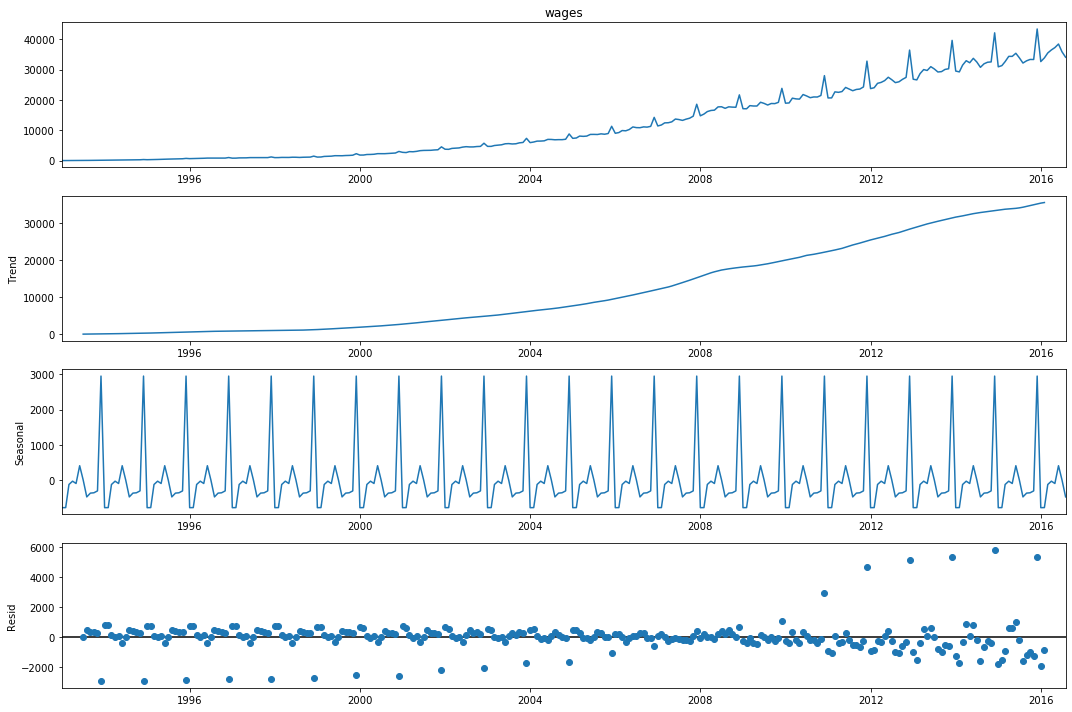

In [40]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary_data.wages).plot()
print("Дики-Фуллера критерий: p=%f" % sm.tsa.stattools.adfuller(salary_data.wages)[1]);

Гипотеза о стационарности отвергается, так как критерий Дики Фуллера сильно выше 0.05

На верхнем из четырёх графиков — исходный ряд. На нижних трёх соответственно тренд, сезонность и остатки.
Сезонный профиль достаточно хорошо выражен. Тренд равномерно повышается. Ряд трудно считать стационарным.

## Стабилизация дисперсии

Применим преобразование Бокса-Кокса:

Параметр преобразования Бокса-Кокса: 0.263202
Дики-Фуллера: p=0.696899


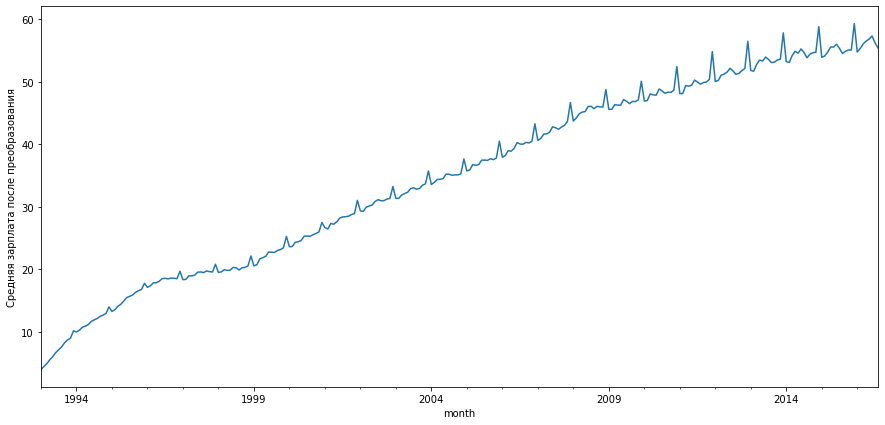

In [41]:
salary_data['wages_box'], lmbda = stats.boxcox(salary_data.wages)
plt.figure(figsize(15,7))
salary_data.wages_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования')
print("Параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary_data.wages_box)[1]);

Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,7. То есть нулевая гипотеза нестационарности ряда подтверждается

## Стационарность и дифференцирование

Применим сезонное дифференцирование:

Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

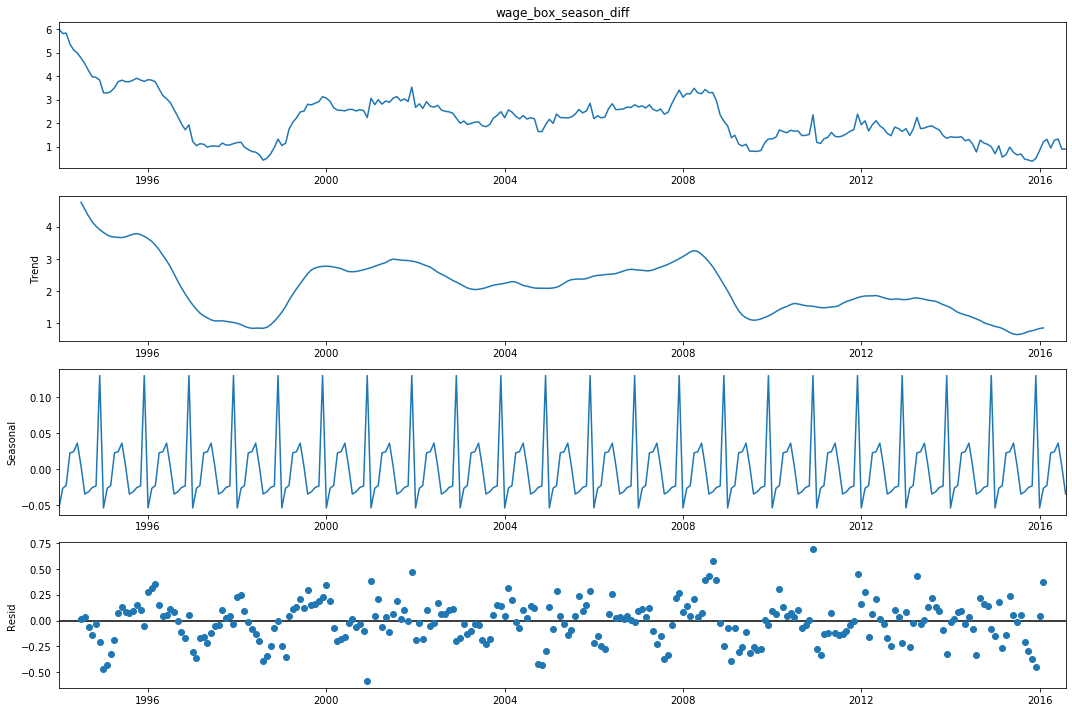

In [42]:
salary_data['wage_box_season_diff'] = salary_data.wages_box - salary_data.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary_data.wage_box_season_diff[12:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary_data.wage_box_season_diff[12:])[1]);

Видим, что сезонное дифференцирование не помогло. Попробуем теперь провести обычное дифференцирование

Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

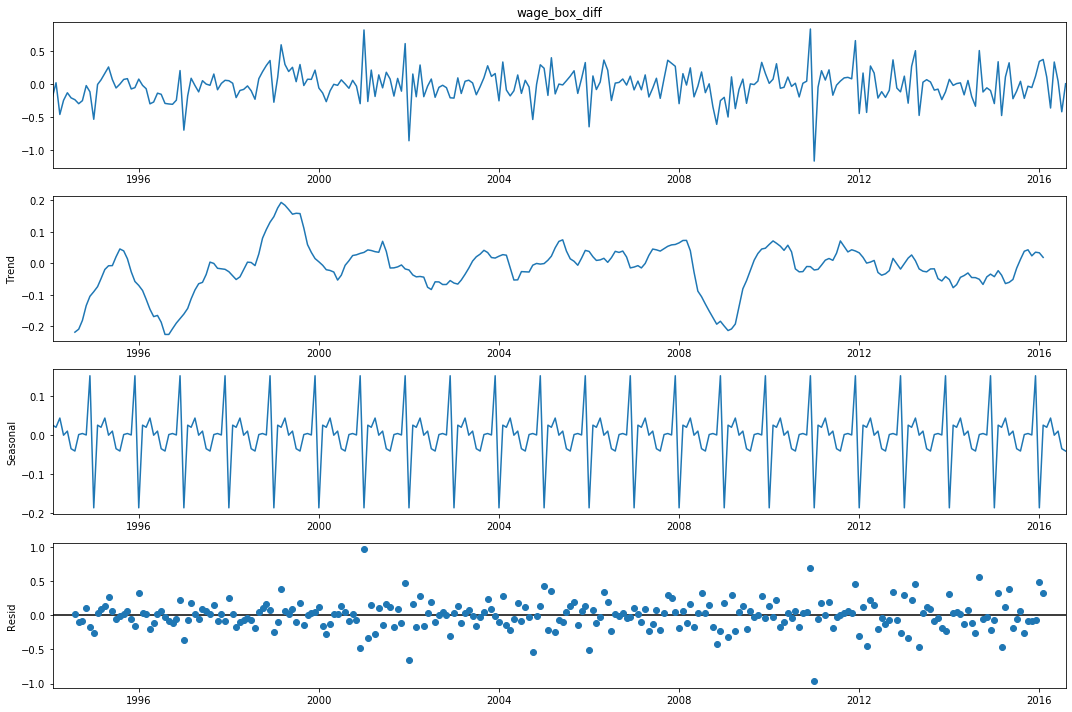

In [43]:
salary_data['wage_box_diff'] = salary_data.wage_box_season_diff - salary_data.wage_box_season_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary_data.wage_box_diff[13:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary_data.wage_box_diff[13:])[1]);

Теперь наш ряд похож на стационарный

In [44]:
salary_data.drop('wage_box_season_diff', axis=1, inplace=True)

## Начальные приближения

Посмотрим на графики автокорреляции (acf) и частичной автокорреляции (pacf)

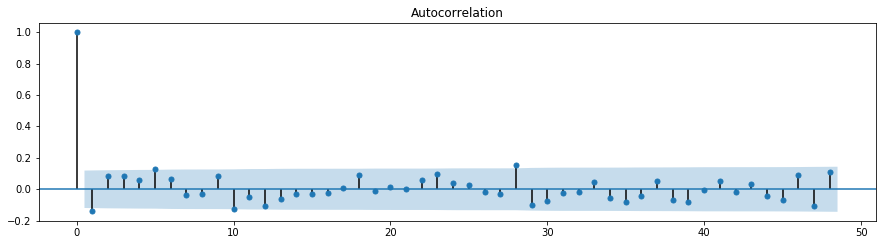

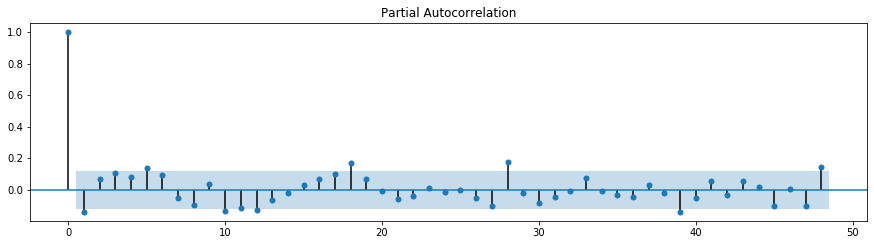

In [45]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary_data.wage_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary_data.wage_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show();

Выберем начальные приближения. Так как сезонных лагов со значимой корреляцией нет, то возьмём Q = 0. 
Итого:
* Q = 0
* q = 1
* P = 1
* p = 1

Непонятно, будет ли у модели с _p = 18_ AIC больше, возможно, модель с _p = 1_ по AIC будет лучше, но было решено начать именно с этого приближения

In [59]:
p_s = range(0, 2)
d = 1
q_s = range(0, 2)
P_s = range(0, 2)
D = 1
Q_s = range(0, 1)

In [60]:
from itertools import product

parameters = product(p_s, q_s, P_s, Q_s)
parameters_list = list(parameters)
parameters_list
print("длина массива параметров: " + str(len(parameters_list)))

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0)]

длина массива параметров: 8


## Обучение и сравнение моделей-кандидатов

Настроим все их и посчитаем для каждой значение информационного критерия Акаике, выберем ту модель, у которой это значение будет минимальным. Выведем информацию о лучшей модели

In [61]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary_data.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('______________________')
print('\n')
print(result_table.sort_values(by = 'aic', ascending=True).head())
print('______________________')
print('\n')
print(best_model.summary())

______________________


     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021912
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832
______________________


                                     SARIMAX Results                                      
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 04 Apr 2021   AIC                              0.341
Time:                                    22:14:09   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025

Построим график

Критерий Стьюдента: 0.090792
Критерий Дики-Фуллера: 0.000003


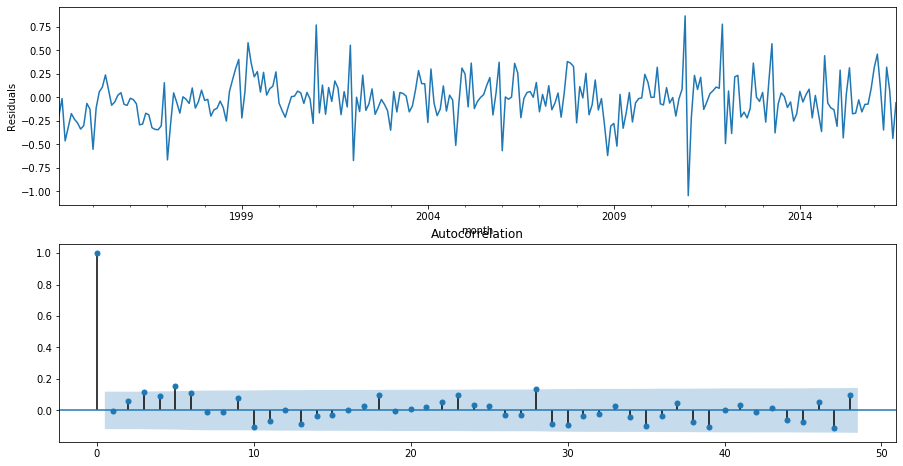

In [62]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: %f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: %f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]);

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы, как видно на коррелограмме

Посмотрим, насколько хорошо модель описывает данные:

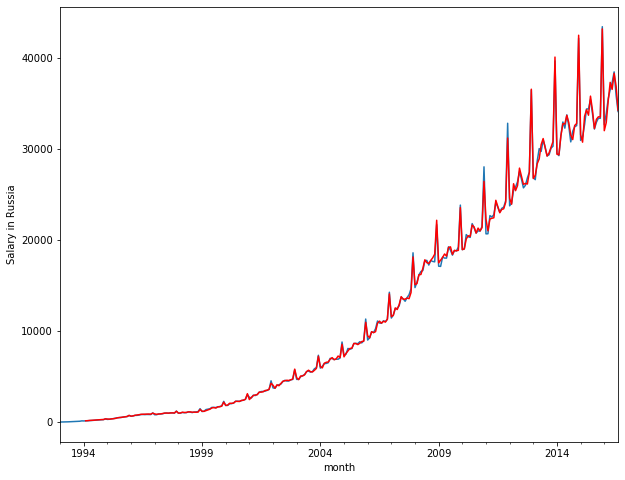

In [63]:
salary_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams["figure.figsize"] = (10,8)

salary_data.wages.plot()
salary_data.model[13:].plot(color='r')
plt.ylabel('Salary in Russia')
plt.show();

## Прогнозирование с помощью финальной модели

Строим график прогноза заработной платы:

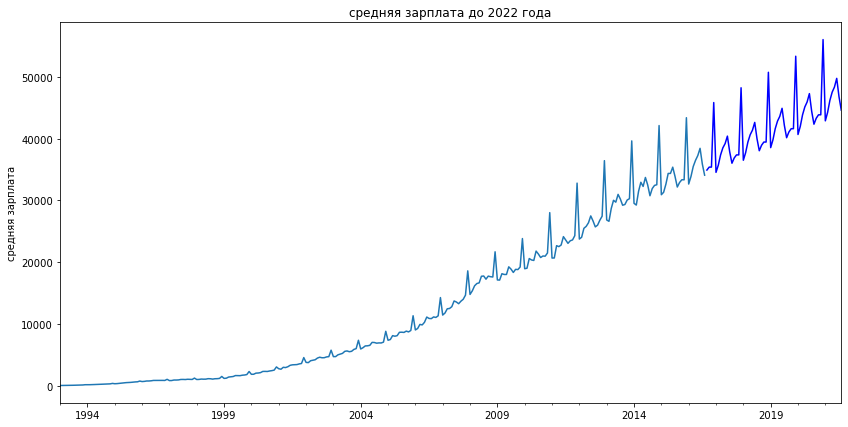

In [64]:
data = salary_data[['wages']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 60)]
for_2022 = pd.DataFrame(index=date_list, columns= data.columns)
data = pd.concat([data, for_2022])
data['forecast'] = invboxcox(best_model.predict(start=284, end=349), lmbda)

plt.figure(figsize(14,7))
data.forecast.plot(color='blue')
plt.ylabel(u'средняя зарплата')
plt.title(u'средняя зарплата до 2022 года')
data.wages.plot()
pylab.show();

![ChessUrl](https://i.gifer.com/origin/38/3854490ac49c724f016ee999e91b13f6_w200.gif "chess")